<h2>Alberto Moro Carrera</h2>

En primer lugar entrenamos el modelo de trenes con el histórico

In [1]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd


df = pd.read_csv('TrainDataRailway.csv', usecols=['distance', 'Climate', 'Date', 'eta', 'eta/km'], sep=",")

# Obtiene el mes de cada fecha (Es lo que realmente afecta al eta)
df['month'] = pd.DatetimeIndex(df['Date']).month 

#Eliminamos valores nulos del set si los hubiera
df = df.dropna()

#Dividimos el dataset en 2, uno para el entrenamiento y otro para predecir y contrastar las predicciones.
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

#Variables que afectan a la predicción del eta
X_train = train_data[['distance', 'Climate', 'month']]

#Convertimos las variables no numéricas por columnas numéricas para cada uno de los valores que estas puedan adoptar,
#Pues el modelo solo funciona con valores numéricos. 
X_train = pd.get_dummies(X_train, columns=['Climate'], prefix='', prefix_sep='')

#Variable a predecir
y_train = train_data['eta/km']

#Algoritmo
modelo_trenes = tree.DecisionTreeRegressor()

#Entrenamos el modelo con los 2 subdataset
modelo_trenes.fit(X_train, y_train)

DecisionTreeRegressor()

Ahora entrenamos el modelo de maritimo

In [2]:
from sklearn import tree
from sklearn.model_selection import train_test_split
import pandas as pd


df = pd.read_csv('TrainDataMaritimo.csv', usecols=['distance', 'Climate', 'Date', 'eta', 'eta/km'], sep=",")

# Obtiene el mes de cada fecha (Es lo que realmente afecta al eta)
df['month'] = pd.DatetimeIndex(df['Date']).month 

#Eliminamos valores nulos del set si los hubiera
df = df.dropna()

#Dividimos el dataset en 2, uno para el entrenamiento y otro para predecir y contrastar las predicciones.
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

#Variables que afectan a la predicción del eta
X_train = train_data[['distance', 'Climate', 'month']]

#Convertimos las variables no numéricas por columnas numéricas para cada uno de los valores que estas puedan adoptar,
#Pues el modelo solo funciona con valores numéricos. 
X_train = pd.get_dummies(X_train, columns=['Climate'], prefix='', prefix_sep='')

#Variable a predecir
y_train = train_data['eta/km']

#ALgoritmo
modelo_barcos = tree.DecisionTreeRegressor()

#Entrenamos el modelo con los 2 subdataset
modelo_barcos.fit(X_train, y_train)

DecisionTreeRegressor()

Ahora entrenamos el modelo de estadías

In [3]:
%pip install xgboost

import xgboost as xgb
from sklearn.model_selection import train_test_split
import pandas as pd


df = pd.read_csv('EstadiasDataset_v1.csv', sep=",")

#Eliminamos valores nulos del set si los hubiera
df = df.dropna()

#Dividimos el dataset en 2, uno para el entrenamiento y otro para predecir y contrastar las predicciones.
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)


#Variables que afectan a la predicción del eta
X_train = train_data[['modo_x', 'modo_y', 'pesoKG']]

#Obtenemos las columnas numéricas de las columnas paramétricas del modo de salida y de llegada
X_train = pd.get_dummies(X_train, columns=['modo_x'], prefix='x', prefix_sep='_')
X_train = pd.get_dummies(X_train, columns=['modo_y'], prefix='y', prefix_sep='_')

#Variable a predecir
y_train = train_data['tiempoMin']

#ALgoritmo que se usará en este caso
modelo_estadias = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

#Entrenamos el modelo con los 2 subdataset
modelo_estadias.fit(X_train, y_train)


Note: you may need to restart the kernel to use updated packages.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

Calculamos el clima en todas las coordenadas que tenemos

In [4]:
#Descomentar siguiente linea en primera ejecución para instalar la dependencia
#%pip install requests

import requests
import pandas as pd
from tqdm import tqdm

#Cargamos se de coordenadas transitables
df = pd.read_csv('Tren_Y_Barco_v2.csv', usecols=['punto', 'lat', 'long', 'modo'], sep=";")

#Correspondencia entre valor de clima devuelto por la API y clima en nuestro modelo.
Sunny = [0,1]
Cloudy = [2, 3]
Rain = [51,53,55,56,57,61,63,66,67,80]
Foggy = [45, 48]
Storm = [65, 81, 82, 95, 96]
Hurricane = [99]
Snow = [71,73,75,77, 85, 86]

#Iteramos las filas y añadimos una barra de progreso (el shape nos da el tamaño del DF de cara a indicar el progreso)
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    latitude = row['lat']
    longitude = row['long']
    #Generamos la URL a la que haremos la petición
    url ="https://api.open-meteo.com/v1/forecast?latitude=" + str(latitude) +"&longitude=" + str(longitude) + "&current_weather=true"
    #Obtenemos la respuesta
    response = requests.get(url)
    data = response.json() # Convertimos la respuesta a JSON y nos quedamos con el campo que nos interesa
    weather_code = data['current_weather']['weathercode']
    #Le damos el valor de clima en función de nuestros climas y el valor devuelto
    if weather_code in Sunny:
        df.loc[index, 'Climate'] = 'Sunny'
    elif weather_code in Foggy:
        df.loc[index, 'Climate'] = 'Foggy'
    elif weather_code in Cloudy:
        df.loc[index, 'Climate'] = 'Cloudy'       
    elif weather_code in Rain:
        df.loc[index, 'Climate'] = 'Rain'
    elif weather_code in Storm:
        df.loc[index, 'Climate'] = 'Storm'
    elif weather_code in Hurricane:
        df.loc[index, 'Climate'] = 'Hurricane'
    elif weather_code in Snow:
        df.loc[index, 'Climate'] = 'Snow'
    else:
        df.loc[index, 'Climate'] = 'No Data'
        

100%|██████████| 1235/1235 [04:59<00:00,  4.13it/s]


En segundo lugar cargamos el set de coordenadas usables para trenes y barcos, obtenemos la distancia entre los puntos y limpiamos.

In [5]:
import pandas as pd
import networkx as nx
from tqdm import tqdm
import math


df_cp = df #Para devolver los puntos al csv posteriormente


df = df.merge(df, how="cross") #Join de cada punto con los demás para generar las aristas del grafo o "tramos"
#Nos quedamos con los puntos no repetidos (quitamos conexion cconsigo mismo y tambien bidirecciones, nos quedamos con una)
df = df.loc[df.apply(lambda x: x["punto_x"] != x["punto_y"] or not any((df["punto_x"] == x["punto_y"]) & (df["punto_y"] == x["punto_x"])), axis=1)]

#Generamos formula de la harvesina para obtener distancias en una esfera
def haversine(lat1, lon1, lat2, lon2):
    #Valores decimales a radianes
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

    #Formula de la harvesina
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    r = 6371 #Radio de la tierra
    return c * r

#Obtenemos la distancia entre cada tramo usando la fórmula de la harvesine
df["distance"] = df.apply(lambda row: haversine(row["lat_x"], row["long_x"], row["lat_y"], row["long_y"]), axis=1)

#Solo nos interesa el primer clima es el que usaremos de referencia
df = df.drop(columns=['Climate_y'])

#Ya que es la que usaremos como clima para los tramos, la renombramos
df = df.rename(columns={'Climate_x': 'Climate'})

#Variables que nos servirán después para obtener el punto más lejano a los demás
farthest_point = None
farthest_distance = 0

#Obtenemos el set de puntos únicos
points = set(df['punto_x']).union(set(df['punto_y']))

#Iteramos todo el set de datos
for point in tqdm(points):
    # select distances from the current point to all other points
    distances = df.loc[(df['punto_x'] == point) | (df['punto_y'] == point), 'distance']
    
    #Obtenemos la menor distancia del punto actual a todos los demás
    min_distance = distances.min()
    
    #Si la distancia minima de este punto es superior a la mayor menor distancia
    #de entre lo puntos previos, guardamos esta distancia como la nueva más lejana

    if min_distance > farthest_distance:
        farthest_point = point
        farthest_distance = min_distance

#Sacamos por pantalla la distancia mínima obtenida
print("DistanciaMinima", farthest_distance)

#Aumentamos empíricamente la distancia para buscar un concilio entre cantidad de "checkpoints" y limitar rodeos innecesarios en la ruta.
df = df.loc[df["distance"] < farthest_distance + 90] #90 Km Nos quedamos solo con las conexiones entre coordenadas de distancia inferior a 90 km, porque si dejamos todos el camino más rápido a cualquier punto sería la recta hasta él

df = df.reset_index(drop=True)


100%|██████████| 1235/1235 [00:10<00:00, 113.95it/s]

DistanciaMinima 1431.4942412621092


A continuación, utilizando el modelo entrenado al principio y con los datos obtenidos, calculamos el "eta" predecido para cada tramo en tiempo real.

In [6]:
import datetime

#Fecha de hoy para obtener una mejor aproximación
today = datetime.date.today()

#Obtenemos el mes de hoy el cual será usado por el modelo.
month = today.month

#Añadimos el mes a todas las filas de tramos en tiempo real
df['month'] = month

#Obtenemos los valores numéricos de los climas
df = pd.get_dummies(df, columns=['Climate'],  prefix='', prefix_sep='') 

#Si alguna de las columnas no existe la creamos y posteriormente la rellenamos con cero, esto se puede dar si alguno de los climas no se da en ese momento en el mundo
#Y por tanto el get_dummies no crea una columna para dicho clima
# Define list of all weather columns
weather_cols = ['Cloudy', 'Foggy', 'Hurricane', 'Rain', 'Storm', 'Sunny']

#Si no encuentra alguna columna esperada el modelo dará error, así que generamos las de los climas que no haya
for col in weather_cols:
    if col not in df.columns:
        df[col] = 0

# Realizamos las predicciones pasando los valores que espera dependiendo de si es un tramo donde se inicia en barco usamos el modelo de barco y si no el de trenes
df.loc[df['modo_x'] == "tren", 'Predicted_eta'] = modelo_trenes.predict(df.loc[df['modo_x'] == "tren", ['distance', 'month'] + weather_cols])
df.loc[df['modo_x'] == "barco", 'Predicted_eta'] = modelo_barcos.predict(df.loc[df['modo_x'] == "barco", ['distance', 'month'] + weather_cols])

#Corregimos el eta que ahora mismo está en eta/km al eta total
df['Predicted_eta'] = df['Predicted_eta'] * df['distance'] #Solo cambia esto

Sumamos el ETA de las Estadias

In [7]:
import pandas as pd

#Escogemos peso
pesoKG = 10000

feature_names = list(X_train.columns)

#Añadimos el peso a todas las filas como una nueva columna
df['pesoKG'] = pesoKG

#Obtenemos las columnas numericas para los dos modos
df = pd.get_dummies(df, columns=['modo_x'], prefix='x', prefix_sep='_')
df = pd.get_dummies(df, columns=['modo_y'], prefix='y', prefix_sep='_')

#Realiamos las predicciones
df.loc[df['x_barco'] != df['y_barco'] , 'Estadia_min'] = modelo_estadias.predict(df.loc[df['x_barco'] != df['y_barco'], ['pesoKG', 'x_barco', 'x_tren', 'y_barco', 'y_tren']])

#Pasamos los minutos en los que trabaja a horas
df['Estadia_horas'] = df['Estadia_min']/60

#Sumamos solo la estadia a la columna de ETA en las filas donde la estadia no es NaN (Donde hay una estadia)
df.loc[df['Estadia_horas'].notna(), 'Predicted_eta'] = df.loc[df['Estadia_horas'].notna(), 'Predicted_eta'].add(df.loc[df['Estadia_horas'].notna(), 'Estadia_horas'])


Calculo Pos

In [8]:
import pandas as pd
from scipy.spatial.distance import cdist



#Obtenemos el dataset sin modificar
dfCalc = pd.read_csv('Tren_Y_Barco_v2.csv', usecols=['punto', 'lat', 'long', 'modo'], sep=";")

#Valores de latitud y longitud de salida (X) y llegada (Y)
X_lat = 72.74726957207835 
X_long = 96.60823585882845
Y_lat = -27.595607763502517 
Y_long = 25.283609234196557

#Obtenemos el punto de inicio y punto de fin
puntoInicio = (X_lat, X_long)
puntoFin = (Y_lat, Y_long)

#Obtenemos la distancia del punto de inicio con todos y escogemos el más cercano
coords = dfCalc[['lat', 'long']].to_numpy()
distances = cdist([puntoInicio], coords)
indiceCercano = distances.argmin()

#El inicio será el más cercano en nuestro mapeado al punto dado
Inicio = dfCalc.loc[indiceCercano, 'punto']

#Obtenemos la distancia del punto de fin con todos y escogemos el más cercano
distances = cdist([puntoFin], coords)
indiceCercano = distances.argmin()

#El fin será el más cercano en nuestro mapeado al punto dado
Fin = dfCalc.loc[indiceCercano, 'punto']

#Por si se quisieran conocer los puntos
#print(Inicio, Fin)

Algoritmo de Dijkstra donde el eta predecido es el peso.

In [9]:
#Generamos el grafo
G = nx.Graph()

#Añadimos las aristas con el eta predecido de peso
G.add_weighted_edges_from(df[["punto_x","punto_y","Predicted_eta"]].values)

#Obtenemos la ruta y su peso total
path = nx.dijkstra_path(G, Inicio, Fin, weight="Predicted_eta")
peso = nx.path_weight(G, path,  weight='weight')

#Sacamos por pantalla los resultados
print(path)
print(peso)


[1185, 789.0, 875.0, 764.0, 122.0, 5.0, 9.0, 25.0, 758.0, 936.0]
335.99062806995494


Sacamos la ruta a un csv 

In [10]:
df_out = pd.DataFrame()
#Le damos de nuevo formato de tabla 
for node in path:
    #Encontramos la fila del dataset que se corresponde con el nodo de la ruta
    row = df_cp.loc[df_cp["punto"] == node]
    #Lo añadimos al dataframe de retorno.
    df_out = df_out.append(row)

df_out = df_out.reset_index(drop=True)
df_out.to_csv('Ruta_Tren_Barco_P1.csv', index=True)

C:\Users\alberto.moro\AppData\Local\Temp\ipykernel_24352\30087508.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_out = df_out.append(row)
C:\Users\alberto.moro\AppData\Local\Temp\ipykernel_24352\30087508.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_out = df_out.append(row)
C:\Users\alberto.moro\AppData\Local\Temp\ipykernel_24352\30087508.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_out = df_out.append(row)
C:\Users\alberto.moro\AppData\Local\Temp\ipykernel_24352\30087508.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_out = df_out.append(row)
C:\Users\alberto.moro\AppData\Local\Temp\ipykernel_24352\300

Grafo de rutas

Drawing large edges: 100%|██████████| 20568/20568 [17:09<00:00, 19.98it/s]
Drawing small edges: 0it [00:00, ?it/s]


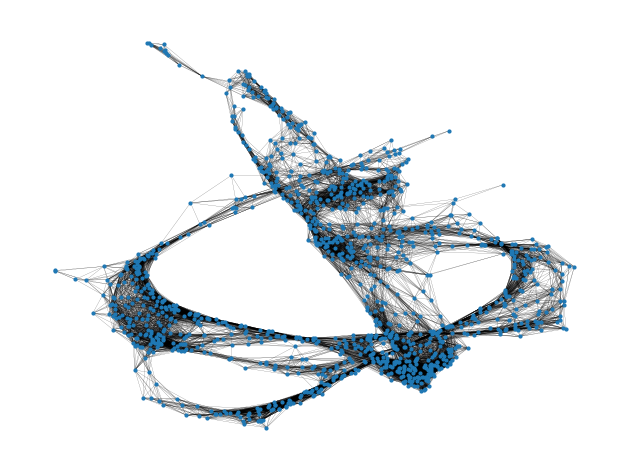

In [11]:
import matplotlib.pyplot as plt

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

#Nodos
nx.draw_networkx_nodes(G, pos, node_size=4)

#Aristas
with tqdm(total=len(elarge), desc="Drawing large edges") as pbar:
    for edge in elarge:
        nx.draw_networkx_edges(G, pos, edgelist=[edge], width=0.1)
        pbar.update(1)

with tqdm(total=len(esmall), desc="Drawing small edges") as pbar:
    for edge in esmall:
        nx.draw_networkx_edges(
            G, pos, edgelist=[edge], width=0.01, alpha=0.005, edge_color="b", style="dashed"
        )
        pbar.update(1)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()